In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
import seaborn as sns
from Test import *
import math

In [22]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [23]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(100,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 0   #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)



var = 30                  # Standard deviation for Gaussian noise
mean = 2000                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 1              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 500
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Control = Data.copy()



num_nodes: 100
IteNumber of Corrupt nodesration 0, Corrupt nodes: []


In [24]:
def normpdf(x, mn, var):
    denom = (2 * np.pi * var)**0.5 
    num = np.exp(-((x - mn)**2) / (2 * var + 1e-6)) 
    return num / (denom + 1e-6)

In [25]:
# Define the normal probability density function
def shownormpdf(mn, var):
    # Step 2: Create x values (input range)
    x = np.linspace(-10, 20, 500)  # Adjust the range to better visualize the Gaussian

    # Step 3: Compute y values (apply the function)
    y = normpdf(x,mn,var)

    # Step 4: Plot the function
    plt.plot(x, y, label='Normal PDF (mean={mn}, variance={var})'.format(mn=mn, var=var))

    # Step 5: Customize the plot
    plt.title("Plot of Normal Probability Density Function")  # Add title
    plt.xlabel("x")  # Label x-axis
    plt.ylabel("f(x)")  # Label y-axis
    plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
    plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
    plt.grid(True)  # Add grid
    plt.legend()

    # Step 6: Show the plot
    plt.show()
    return 0


In [26]:
def nodeSelection(max_iters, num_nodes):
    #Selecting nodes for its turn
    nodes_list = []
    for i in range(max_iters):
        nodes_list.append(np.random.randint(0,num_nodes))
    return nodes_list

In [27]:
def PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging):
    Seed = 2001  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed) 
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x=np.zeros([num_nodes,1])
    converged = False
    Error = np.array([])

    #initialise A_ij
    A_ij=calc_incidence_nested(G)

    #initialise z_ij and y_ij
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    temp_z = np.zeros((num_nodes, num_nodes))
    count=0

    while not converged and count < max_iters:
        #update x_i


        for i in range(num_nodes):
            x[i] = Data[i]
            for j in G.neighbors(i):
                x[i]=x[i]-A_ij[i][j]*z[i][j]
            x[i]=x[i]/(1+c*G.degree(i))
            # print(f"x[{i}]: {x[i]}")
            #update y_ij
            for j in G.neighbors(i):
                temp_z[j][i] = y[i][j]
                y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])
            # print(f"y[{i}]: {y[i]}")


            mask = np.ones(len(x), dtype=bool)
            mask[CorruptClients] = False 
            diff = (x - avg_temp)[mask]

            if np.linalg.norm(diff)< tolerance:
                print(f'Iteration {count}, Norm of difference: {Error:.8f}')
                converged = True

            for j in G.neighbors(i):    
                z[i][j] = averaging * y[j][i] + (1 - averaging) * z[i][j]
                Error = np.append(Error, np.linalg.norm(diff))
                count = count + 1

    print(f"x = {x}")            
    return Error,count, x

In [28]:
# def ADMM(Data, G, avg_temp, tolerance, rho, max_iters,Control):

#     Seed = 2001  # for reproducibility
#     random.seed(Seed)
#     np.random.seed(Seed) 
#     torch.manual_seed(Seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(Seed)
#         torch.cuda.manual_seed_all(Seed)
        
#     # Create the histogram
#     plt.figure(figsize=(6,4))
#     plt.hist(Control, bins=20, edgecolor='black', alpha=0.7)
#     plt.title("Distribution of data")
#     plt.xlabel("Value")
#     plt.ylabel("Frequency")

#     plt.tight_layout()
#     plt.show()

#     num_nodes = G.number_of_nodes()
#     x=np.zeros([num_nodes,1])
#     converged = False
#     Error = np.array([])
    
#     #initialise z_ij and y_ij
#     z = np.zeros((num_nodes, num_nodes))
#     y = np.zeros((num_nodes, num_nodes))

#     count=0
#     while not converged and count < max_iters:
#         node_list = list(range(num_nodes))
#         # print(f"This is node {i}")

#         for i in range(num_nodes):
#             neighbors_i = list(G.neighbors(i))
#             for j in G.neighbors(i):
#                 # Update x[i]
#                 numerator_i = Data[i]
#                 for nbr in neighbors_i:
#                     numerator_i = numerator_i + rho * z[i][nbr] - y[i][nbr]
#                 x[i] = numerator_i / (1 + rho * G.degree(i))

#                 # Update neighbors of j to update x[j]
#                 neighbors_j = list(G.neighbors(j))
#                 numerator_j = Data[j]
#                 for nbr in neighbors_j:
#                     numerator_j = numerator_j + rho * z[j][nbr] - y[j][nbr]
#                 x[j] = numerator_j / (1 + rho * G.degree(j))

#                 # Compute error and check convergence
#                 diff = x - avg_temp
#                 norm_diff = np.linalg.norm(diff)
#                 Error = np.append(Error, norm_diff)
#                 # count = count + 1
#                 if norm_diff < tolerance:
#                     print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
#                     # converged = True
                        
#                 z[i][j] = 0.5 * (x[i] + x[j])
#                 z[j][i] = 0.5 * (x[i] + x[j])
#                 Error = np.append(Error, norm_diff)
#                 # Error = np.append(Error, norm_diff)
#                 count = count + 1

#                 y[i][j] = y[i][j] + rho * (x[i] - z[i][j])
#                 y[j][i] = y[j][i] + rho * (x[j] - z[j][i])
#                 Error = np.append(Error, norm_diff)
#                 # Error = np.append(Error, norm_diff)
#                 count = count + 1



#     print(f"x = {x}")
#     return Error,count, x

In [29]:
def main():
    calc_mean = 0
    max_iters=1000 * num_nodes             #PDMM max iterations
    averaging = 1/2           #Averaging alpha
    tolerance=-1        #PDMM tolerance
    c=1                       #PDMM c
    nodes_list = nodeSelection(max_iters, num_nodes)
    avg_temp = np.mean(Data)
    for i in range(num_nodes):
        if CorruptClients[i] == 1:
                Data[i] = np.random.normal(mean,  np.sqrt(var))

    print(avg_temp)
    Error = []
    Error_A = []
    Error, Transmission,calc_mean = PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging)
    # Error_A, Transmission,calc_mean = ADMM(Data, G, avg_temp, tolerance, c, max_iters,Control)
    print(calc_mean)
    
    plt.figure(figsize=(10, 4))
    # Plot  error
    plt.plot(range(len(Error)), Error, label='PDMM Convergence')
    # plt.plot(range(len(Error_A)), Error_A, label='ADMM Convergence')
    plt.yscale('log')
    plt.title('Error Convergence Over Iteration Rounds')
    plt.xlabel('Iteration Round')
    plt.ylabel('Norm Error')
    plt.legend()

25.283100449628563


C:\Users\za_re\AppData\Local\Temp\ipykernel_33036\868566960.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])


x = [[25.07648226]
 [25.06167557]
 [25.08363768]
 [25.06354641]
 [25.06988655]
 [25.15571444]
 [25.06378492]
 [25.14535676]
 [25.08499156]
 [25.07983483]
 [25.0523395 ]
 [25.08911782]
 [25.07516999]
 [25.11641709]
 [25.06657555]
 [25.0661605 ]
 [25.09389255]
 [25.14206969]
 [25.13479518]
 [25.06858133]
 [25.11682628]
 [25.12572559]
 [25.09869037]
 [25.10671563]
 [25.15281359]
 [25.11746418]
 [25.05290366]
 [25.06009218]
 [25.05808966]
 [25.06432397]
 [25.11510078]
 [25.14341748]
 [25.13343513]
 [25.081855  ]
 [25.06974827]
 [25.07411964]
 [25.1577144 ]
 [25.06432124]
 [25.16012848]
 [25.15132468]
 [25.06214036]
 [25.09826232]
 [25.08329916]
 [25.05242627]
 [25.0563491 ]
 [25.086096  ]
 [25.09936872]
 [25.09241786]
 [25.10185397]
 [25.08232659]
 [25.15472103]
 [25.10471627]
 [25.06976796]
 [25.11380165]
 [25.12039422]
 [25.07483195]
 [25.15864389]
 [25.14681281]
 [25.11125318]
 [25.06633019]
 [25.09115149]
 [25.15666436]
 [25.14295653]
 [25.08837137]
 [25.06131106]
 [25.07442801]
 [25.0

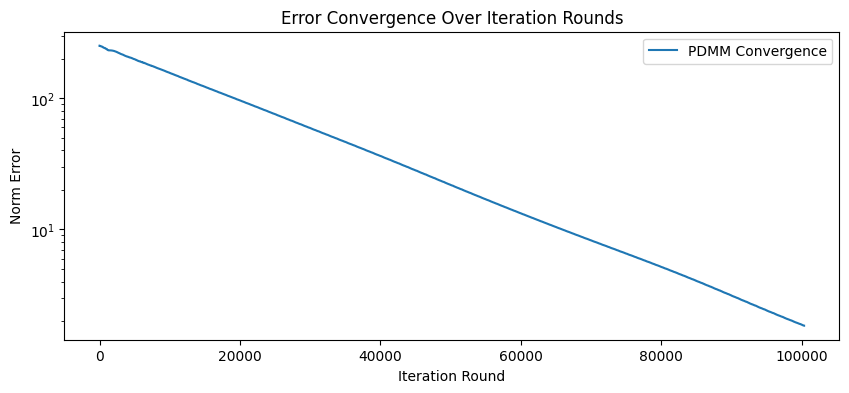

In [30]:
if __name__ == '__main__':
    main()